<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics" data-toc-modified-id="Basics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics</a></span><ul class="toc-item"><li><span><a href="#Custom-sensor-plugins-for-Mitsuba-3" data-toc-modified-id="Custom-sensor-plugins-for-Mitsuba-3-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Custom sensor plugins for Mitsuba 3</a></span><ul class="toc-item"><li><span><a href="#Install-Mitsuba-3" data-toc-modified-id="Install-Mitsuba-3-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Install Mitsuba 3</a></span></li><li><span><a href="#Plugin-for-pinhole-camera" data-toc-modified-id="Plugin-for-pinhole-camera-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Plugin for pinhole camera</a></span></li><li><span><a href="#Plugin-for-thin-lens-camera" data-toc-modified-id="Plugin-for-thin-lens-camera-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Plugin for thin lens camera</a></span></li><li><span><a href="#Plugin-for-telecentric-camera" data-toc-modified-id="Plugin-for-telecentric-camera-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Plugin for telecentric camera</a></span></li></ul></li><li><span><a href="#Custom-emitter-plugins-for-Mitsuba" data-toc-modified-id="Custom-emitter-plugins-for-Mitsuba-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Custom emitter plugins for Mitsuba</a></span><ul class="toc-item"><li><span><a href="#Plugin-for-telecentric-illumination" data-toc-modified-id="Plugin-for-telecentric-illumination-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Plugin for telecentric illumination</a></span></li></ul></li><li><span><a href="#Fourier-transform" data-toc-modified-id="Fourier-transform-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Fourier transform</a></span><ul class="toc-item"><li><span><a href="#Convolution-in-the-Fourier-domain" data-toc-modified-id="Convolution-in-the-Fourier-domain-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Convolution in the Fourier domain</a></span></li><li><span><a href="#Hybrid-images" data-toc-modified-id="Hybrid-images-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Hybrid images</a></span></li></ul></li></ul></li></ul></div>

# Basics

## Custom sensor plugins for Mitsuba 3

The [Mitsuba renderer](https://www.mitsuba-renderer.org/) is a photorealistic renderer in the style of the famous *Physically Based Renderer (PBRT)*, which can be extended by customized add ons, so-called plugins. This allows novel sensor concepts or light sources to  be added to Mitsuba. 

The Mitsuba renderer consists of five main components whose interaction is illustrated in the following Figure:



<img src="figures/ex1/RendererPrinzip.svg" style="max-height:40vh">

Every scene that should be rendered with Mitsuba consists of at least a sensor component, such as a camera, and a light emitter. Further objects can be composed out of so-called shapes or they can be added by means of their CAD model.

To synthesize the sought camera image, a classical ray tracing algorithm is employed: The renderer component generates two-dimensional continuous sensor samples $\mathbf{p}^\mathrm{b}$ according to a certain sampling strategy and, if requested by the sensor plugin, additional aperture samples $\mathbf{p}^\mathrm{a}$ and passes them to the sensor plugin. 
For example, an aperture sample is needed by plugins modeling conventional cameras (e.g., the thin lens camera model), where every pixel integrates incident light rays coming from multiple directions. The sensor calculates the ray of sight corresponding to the received spatial sample $\mathbf{p}^\mathrm{b}$ and, if applicable, the aperture sample $\mathbf{p}^\mathrm{a}$ according to its sensor model. Rays of sight are defined as tuples $(\mathbf{o},\mathbf{d})$ of a point of origin $\mathbf{o}$ and the direction of propagation $\mathbf{d}$. The ray of sight is passed back to the renderer, which starts tracing the ray through the modeled scene. The ray might hit the surface of an object, get absorbed, reflected or refracted and might receive new directions of propagation. The tracing is continued until no further intersection happens (i.e., the ray directs into empty space), a fixed number of intersections is exceeded or a light source has been reached. In the latter case, the reached light source component is queried for its radiance $R$ with respect to the current ray of sight. The renderer propagates the received radiance $R$ back along the whole optical path of the traced ray by taking all optical effects that occur along the way and the reflectance characteristics of all involved surfaces into account. The resulting radiance $R'$ and the current sensor sample $\mathbf{p}^\mathrm{b}$ are passed to the film component which successively aggregates the received radiances and finally creates the output image.

In the following exercises, several plugins for Mitsuba will be implemented.

### Install Mitsuba 3

Run the following command in a >= Python 3.8-environment:

In [ ]:
!pip install mitsuba

Import mitsuba, drjit and matplotlib and set the default mitsuba variant:

In [51]:
variant = "scalar_rgb"
#variant = "cuda_ad_rgb"
#variant = "llvm_ad_rgb"

import os as os
os.environ["MI_DEFAULT_VARIANT"] = variant

import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt

mi.set_variant(variant)

### Plugin for pinhole camera

Implement a class for the pinhole camera.<br> Fill in the correct code at the marked gap.

<hr>

Since the mitsuba documentation is insufficient, here is a description of the signature of the relevant function `sample_ray_differential`:

`time`: Not needed, for dynamic scenes only.<br>
`sample1`: 1D-sample for wavelenght. Not needed, for high spectral resolution only.<br>
`sample2`: 2D-sample $\in [0,1] \times [0,1]$ for the spatial position on the sensor / image plane.<br>
`sample3`: 2D-sample $\in [0,1] \times [0,1]$ for the spatial position on the aperture plane (i.e., where the pinhole is).<br>
`active`: Boolean denoting whether this sensor is currently active. Not needed, for multi-sensor scenarios only.<br><br>
Returns tuple `(RayDifferential3f : rayd, Color3f : weight)`: <br>
`rayd`: The normalized ray of sight corresponding to the provided samples, in world coordinates.<br>
`weight`: Weight factors for the individual color channels to account for spectrally varying sensor sensitivity. Can be set to $(1.0, 1.0, 1.0)$.


<hr>

The pinhole camera is described via the parameters<br>
`to_world`: The transformation from camera to world coordinates.<br>
`img_dist`: The distance between the aperture plane (with the pinhole) and the sensor plane.<br>
`sen_size`: The size of the (square) sensor plane (hence only one parameter).<br>
`pinh_rad`: The radius of the pinhole.

In [52]:
class pinhole_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.img_dist = props['img_dist']
        self.sen_size = props['sen_size']
        self.pinh_rad = props['pinh_rad']
        self.filmsize = (self.sen_size, self.sen_size)
            
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        
        p_a_2d = self.pinh_rad * mi.warp.square_to_uniform_disk_concentric(sample3)
        p_a = mi.Point3f(p_a_2d[0], p_a_2d[1], 0.0)
        
        p_s = mi.Point3f((sample2[0]-0.5) * self.filmsize[0], (sample2[1]-0.5) * self.filmsize[1], -1.0 * self.img_dist)
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = p_a
        rayd.d = p_a - p_s
        
        rayd.d = dr.normalize(rayd.d)
        rayd.d = self.to_world.transform_affine(rayd.d)
        
        return (rayd, mi.Color3f(1.0, 1.0, 1.0))

    
    def to_string(self):
        return ('pinhole_sensor[\n'
                '    img_dist=%s,\n'
                '    sen_size=%s,\n'
                '    pinh_rad=%s,\n'
                ']' % (self.img_dist, self.sen_size, self.pinh_rad))
        

We now register the sensor so that it can be used for rendering:

In [3]:
mi.register_sensor("pinhole_sensor", lambda props: pinhole_sensor(props))

Describe a scene with a single illuminating sphere (i.e., an area light source with the shape of a sphere) observed by a pinhole camera.

In [4]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'sphere' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 1.0,
        },
    },
    'center': [0, 0, 5],
    'radius': 2,
        
    },
    'sensor': {
        'type': 'pinhole_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'img_dist': 2.5,
        'sen_size': 5.0,
        'pinh_rad': 0.001,
        'film': {'type': 'hdrfilm',
      'width': 256,
      'height': 256,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 2},
    }
})



Render the scene:

In [5]:
image = mi.render(scene)

Display the resulting image:

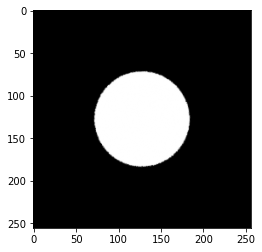

In [6]:
plt.figure()
plt.imshow(image)

Try different values for the pinhole radius:

In [7]:
radi = dr.linspace(dr.scalar.ArrayXf,0.001, 1.0, 20)

images = []

for rad in radi:
    scene.sensors()[0].pinh_rad = rad
    cur_img = mi.render(scene)
    images.append(cur_img)

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
#np.savez_compressed("pinhole-images",images)
np.save("pinholes", images)

<IPython.core.display.Javascript object>


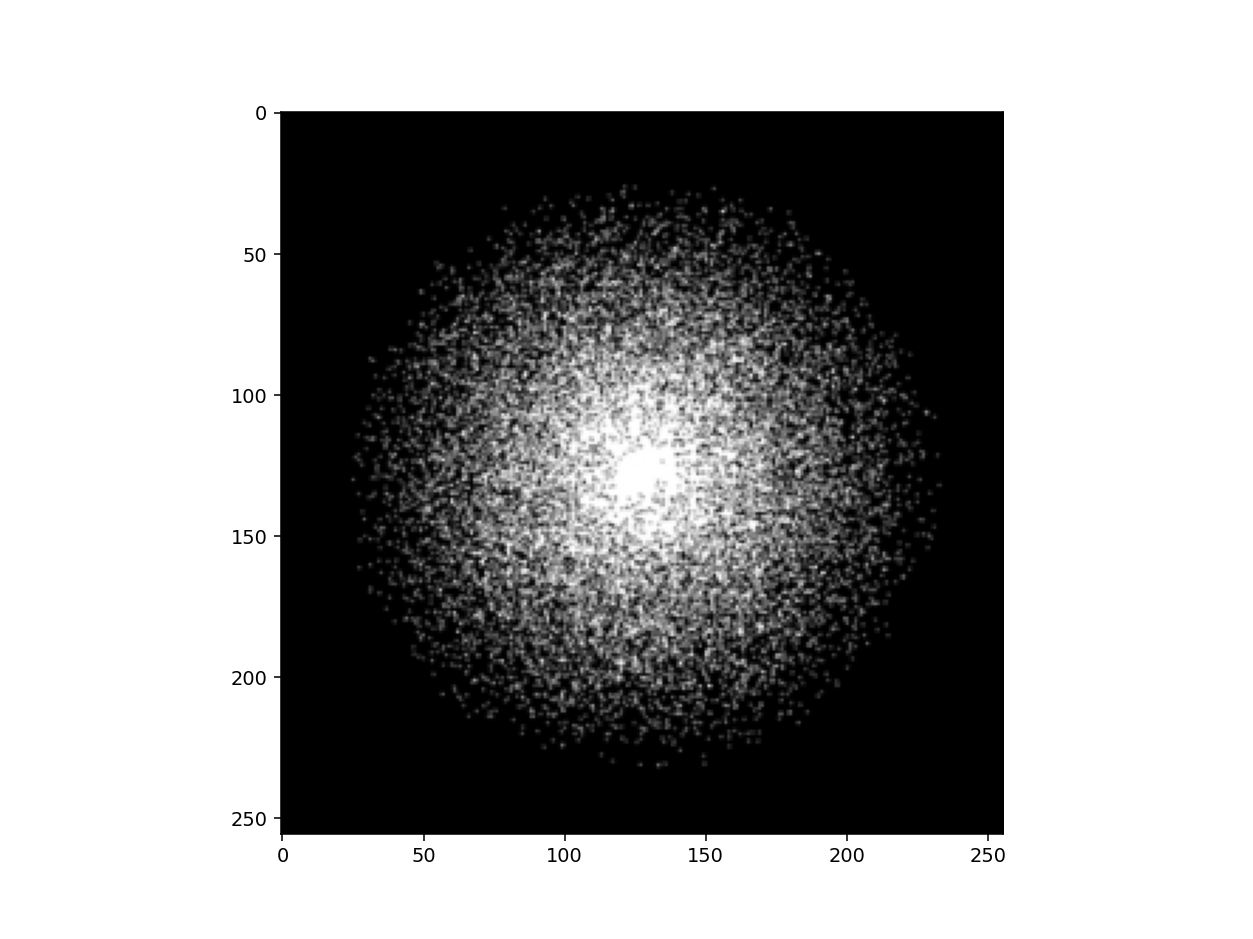

interactive(children=(IntSlider(value=0, description='v', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(v)>

In [53]:
plt.figure()
interact(lambda v: plt.imshow(images[v]), v=widgets.IntSlider(min=0,max=len(images)-1, step=1, value=0))

### Plugin for thin lens camera

Implement a class for the thin lens camera.<br> Fill in the correct code at the marked gap.

<hr>

The thin lens camera is described via the parameters<br>
`to_world`: The transformation from camera to world coordinates.<br>
`foc_len`:  The focal length of the lens. <br>
`img_dist`: The distance between the aperture plane (with the lens) and the sensor plane.<br>
`sen_size`: The size of the (square) sensor plane (hence only one parameter).<br>
`lens_rad`: The radius of the lens.

In [10]:
class thin_lens_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.foc_len  = props['foc_len']
        self.img_dist = props['img_dist']
        self.sen_size = props['sen_size']
        self.lens_rad = props['lens_rad']
        self.filmsize = (self.sen_size, self.sen_size)
            
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        
        p_a_2d = self.lens_rad * mi.warp.square_to_uniform_disk_concentric(sample3)
        p_a = mi.Point3f(p_a_2d[0], p_a_2d[1], 0.0)
        
        p_s = mi.Point3f((sample2[0]-0.5) * self.filmsize[0], (sample2[1]-0.5) * self.filmsize[1], -1.0 * self.img_dist)
        
        p_o = p_s / (-1.0 * self.img_dist) * 1/(1/self.foc_len - 1/self.img_dist)
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = p_a
        rayd.d = p_o - p_a
        
        rayd.d = dr.normalize(rayd.d)
        rayd.d = self.to_world.transform_affine(rayd.d)
        
        return (rayd, mi.Color3f(1.0, 1.0, 1.0))

    
    def to_string(self):
        return ('thin_lens_sensor[\n'
                '    foc_len=%s,\n'
                '    img_dist=%s,\n'
                '    sen_size=%s,\n'
                '    lens_rad=%s,\n'
                ']' % (self.foc_len, self.img_dist, self.sen_size, self.lens_rad))
        

We now register the sensor so that it can be used for rendering:

In [11]:
mi.register_sensor("thin_lens_sensor", lambda props: thin_lens_sensor(props))

Describe a scene with a single illuminating sphere (i.e., an area light source with the shape of a sphere) with radius of $1$ observed by a thin lens camera.<br>
The sphere shall be located at $\mathbf{p}^\mathrm{c}=(0,0,8)^\intercal$ and shall be sharply imaged by the camera with a magnification of $V=2.0$. The sensor shall have a physical size of $10.0 \times 10.0$ with a resolution of $100 \times 100$ pixel.<br> Experiment with different lens radii.

In [12]:
g = 8.0

In [13]:
V = 2.0

In [14]:
f = g/(1/V+1)

In [15]:
b = 1/(1/f - 1/g)

In [16]:
f,b,g,V

(5.333333333333333, 16.0, 8.0, 2.0)

In [17]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'sphere' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 1.0,
        },
    },
    'center': [0, 0, g+4],
    'radius': 1,
        
    },
    'sensor': {
        'type': 'thin_lens_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'foc_len' : f,
        'img_dist': b,
        'sen_size': 10.0,
        'lens_rad': 1.0,
        'film': {'type': 'hdrfilm',
      'width': 100,
      'height': 100,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 32},
    }
})



Render the scene:

In [18]:
image = mi.render(scene)

Display the resulting image:

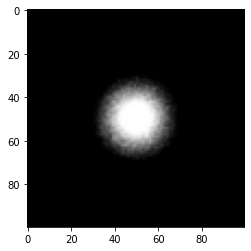

In [19]:
plt.imshow(image)

### Plugin for telecentric camera

Implement a class for a telecentric camera.<br> Fill in the correct code at the marked gap.

<hr>

The telecentric camera is described via the parameters<br>
`to_world`: The transformation from camera to world coordinates.<br>
`foc_len`:  The focal length of the lens. <br>
`img_dist`: The distance between the aperture plane (with the lens) and the sensor plane.<br>
`sen_size`: The size of the (square) sensor plane (hence only one parameter).<br>
`lens_rad`: The radius of the lens.<br>
`stop_rad`: The radius of the open circular region of the telecentric stop.

In [20]:
class telecentric_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.foc_len  = props['foc_len']
        self.img_dist = props['img_dist']
        self.sen_size = props['sen_size']
        self.lens_rad = props['lens_rad']
        self.stop_rad = props['stop_rad']
        self.filmsize = (self.sen_size, self.sen_size)
            
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
       
        p_stop_2d = self.stop_rad * mi.warp.square_to_uniform_disk_concentric(sample3)
        p_stop = mi.Point3f(p_stop_2d[0], p_stop_2d[1], -1.0 * self.foc_len)
        
        p_s = mi.Point3f((sample2[0]-0.5) * self.filmsize[0], (sample2[1]-0.5) * self.filmsize[1], -1.0 * self.img_dist)
        
        p_o = p_s / (-1.0 * self.img_dist) * 1/(1/self.foc_len - 1/self.img_dist)
        
        p_lens = (p_stop - p_s) / (self.img_dist - self.foc_len) * self.img_dist + p_s
       
        #Set weight to 0.0 if we miss the lens
        weight = 1.0
        if dr.sqrt(p_lens[0]**2 + p_lens[1]**2) >= self.lens_rad:
            weight = 0.0
        
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = p_lens
        rayd.d = p_o - p_lens
        
        rayd.d = dr.normalize(rayd.d)
        rayd.d = self.to_world.transform_affine(rayd.d)
                
        
        return (rayd, mi.Color3f(weight, weight, weight))

    
    def to_string(self):
        return ('telecentric_sensor[\n'
                '    foc_len=%s,\n'
                '    img_dist=%s,\n'
                '    sen_size=%s,\n'
                '    lens_rad=%s,\n'
                '    stop_rad=%s,\n'
                ']' % (self.foc_len, self.img_dist, self.sen_size, self.lens_rad, self.stop_rad))
        

We now register the sensor so that it can be used for rendering:

In [21]:
mi.register_sensor("telecentric_sensor", lambda props: telecentric_sensor(props))

Use the same scene as for the thin lens camera.<br> Experiment with different stop radii and distances of the object to the camera.

In [22]:
g = 8.0

In [23]:
V = 2.0

In [24]:
f = g/(1/V+1)

In [25]:
b = 1/(1/f - 1/g)

In [26]:
f,b,g,V

(5.333333333333333, 16.0, 8.0, 2.0)

In [27]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'sphere' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 1.0,
        },
    },
    'center': [0, -1.5, g],
    'radius': 1,
        
    },
    
    'sphere2' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 1.0,
        },
    },
    'center': [0, 1.5, g+4],
    'radius': 1,
        
    },
    
    
    'sensor': {
        'type': 'telecentric_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'foc_len' : f,
        'img_dist': b,
        'sen_size': 10.0,
        'lens_rad': 2.0,
        'stop_rad': 0.2000,
        'film': {'type': 'hdrfilm',
      'width': 100,
      'height': 100,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 8},
    }
})



Render the scene:

In [28]:
image = mi.render(scene)

Display the resulting image:

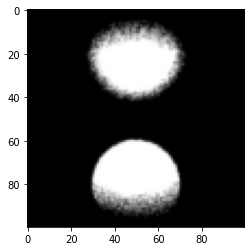

In [29]:
plt.imshow(image)

In [ ]:
plt.imshow(image)

## Custom emitter plugins for Mitsuba

### Plugin for telecentric illumination 

We will now create a custom emitter plugin for Mitsuba.<br>

The telecentric illumination is supposed to act like an area light source with the additional possibility to control the emission angle around the surface normal. It will be attached to a shape (i.e., a sphere or a rectangle) to model its geometry.

Since the mitsuba documentation is insufficient, here is a description of the signature of the relevant function `eval(self, si:mi.SurfaceInteraction3f, active=True)`:

`si:mi.SurfaceInteraction3f`: Describes the interaction (i.e., the intersection) between a traced ray of sight and the light source (for more infos see below).<br>
`active=True`: Not needed here, can remain `True`.<br><br>
Returns `mi.Color3f`: The spectrum emitted in the direction of the traced ray (can also be `(0.0, 0.0, 0.0)` if no light is emitted in the respective direction.).<br>


<br><br>
The `si : SurfaceInteraction3f` record contains two particularly useful parameters:<br>
`si.n : mi.Vector3f` : The normal vector of the attached shape at the evaluated intersection.<br>
`si.wi : mi.Vector3f`: The direction of the traced ray (usually pointing towards the shape).

<hr>

The telecentric illumination is described via the parameters<br>
`acc_angle`: The maximum accepted angle, i.e., the angle between a ray of sight of a sensor and the surface normal of the light source inside which light is emitted.<br>
`radiance`: The spectrum that is emitted inside the accepted angle.<br>

Fill in the gaps in the code below, so that the parameterized spectrum `self.radiance` is only emitted, if at an intersection the angle between the surface normal and the traced ray is smaller than the accepted angle `self.acc_angle`.

In [30]:
class telecentric_area_light (mi.Emitter):
    def __init__(self, props):
        mi.Emitter.__init__(self, props)
        self.acc_angle = dr.deg2rad(props['acc_angle'])
        self.radiance = mi.Color3f(props['radiance'])
        self.flags = mi.EmitterFlags.Surface | mi.EmitterFlags.SpatiallyVarying
    
    def angleBetweenVectors(self, a:mi.Vector3f, b:mi.Vector3f):
        return dr.acos(dr.dot(a,b) / (dr.norm(a) * dr.norm(b)))
    
    def eval(self, si:mi.SurfaceInteraction3f, active=True):
        
        res = mi.Color3f(0.0, 0.0, 0.0)
        
        if self.angleBetweenVectors(si.n, si.wi * -1.0) <= self.acc_angle:
            res = self.radiance
        
        return res

    def sample_direction(self, it:mi.Interaction3f, sample, active=True):
        dirsam = mi.DirectionSample3f()
        return (mi.DirectionSample3f(), mi.Color3f())
    
    def to_string(self):
        return ('telecentric_area_light[\n'
                '    acc_angle=%s,\n'
                '    radiance=%s,\n'
                ']' % (dr.rad2deg(self.acc_angle), self.radiance))
        

We now register the new plugin as an emitter plugin:

In [31]:
mi.register_emitter("telecentric_area_light", lambda props: telecentric_area_light(props))

Render a test scene where a telecentric camera observes a rectangular telecentric area light source. Experiment with the acceptance angle and the stop radius of the telecentric camera.

In [54]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'rect' : {
        'type': 'rectangle',
        'emitter': {
            'type': 'telecentric_area_light',
            'radiance': mi.Color3f(1.0,1.0,1.0),
            'acc_angle': 20.0
    },
        'flip_normals' : True,
        'to_world': mi.Transform4f.translate(mi.Point3f(0,0,g))@mi.Transform4f.scale(mi.Point3f(2,2,2))
        
    },
    
    
    
    'sensor': {
        'type': 'telecentric_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'foc_len' : f,
        'img_dist': b,
        'sen_size': 10.0,
        'lens_rad': 10.0,
        'stop_rad': 0.1000,
        'film': {'type': 'hdrfilm',
      'width': 100,
      'height': 100,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 8},
    }
})



In [55]:
image = mi.render(scene)

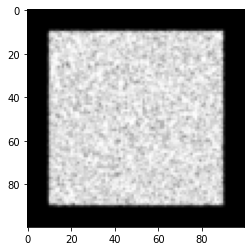

In [34]:
plt.imshow(image)

## Fourier transform

### Convolution in the Fourier domain

Implement a function `fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray` that performs a 2D-convolution of the input image `img` with the convolution kernel `kernel` in the Fourier domain.

Validate via the function `np.allclose` and an example image that your result is equal to the result when performing the convolution in the spatial domain with `scipy.ndimage.convolve`.

In [35]:
import numpy as np
import scipy.ndimage as ndimage
from scipy import misc

In [36]:
def pad_like(inp : np.ndarray, like : np.ndarray):
    to_pad = tuple(np.int32((np.array(like.shape) - np.array(inp.shape))/2))
    return np.pad(inp, ((to_pad[0], to_pad[0]), (to_pad[1], to_pad[1])))

In [39]:
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
    kernel_padded = pad_like(kernel, img)
    kernel_padded_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
    
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

In [38]:
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    result = np.zeros_like(img) ## replace with your solution
    
    return result

Test your function:

<ipython-input-40-b5b0b4d6cf71>:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = np.float32(misc.face(gray=True))[0:-1, 0:-1]


Is your solution correct: True


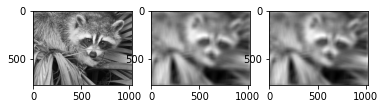

In [40]:
img = np.float32(misc.face(gray=True))[0:-1, 0:-1]
kernel = np.ones((51,51))

res_fourier = fourier_conv(img, kernel)
res_spatial = ndimage.convolve(img, kernel, mode='wrap') ## Which mode do you have to use?

print(f"Is your solution correct: {np.allclose(res_fourier, res_spatial)}")

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(res_spatial, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(res_fourier, cmap='gray')


In [ ]:
img = np.float32(misc.face(gray=True))[0:-1, 0:-1]
kernel = np.ones((51,51))

res_fourier = fourier_conv(img, kernel)
res_spatial = ndimage.convolve(img, kernel, mode='???') ## Which mode do you have to use?

print(f"Is your solution correct: {np.allclose(res_fourier, res_spatial)}")

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(res_spatial, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(res_fourier, cmap='gray')


### Hybrid images

Read the paper

*Hybrid images* by Aude Oliva et al. (https://dl.acm.org/doi/abs/10.1145/1141911.1141919).

Implement a function that takes two input images and combines them by high pass-filtering the first one and low pass-filtering the second one, so that in the resulting images, the first original image can be seen when viewing from a close distance and the second original image can be seen from a far distance.

In [41]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
%matplotlib notebook
book = False

In [43]:
def make_odd_shapes(inp : np.ndarray) -> np.ndarray:
    if (inp.shape[0] % 2 == 0):
        inp = inp[0:-1,:]
    if (inp.shape[1] % 2 == 0):
        inp = inp[:,0:-1]
    return inp

In [44]:
img1 = misc.face(gray=True)[0:-1, 0:-1]
img2 = pad_like(make_odd_shapes(cv2.cvtColor(plt.imread("figures/ex1/Hund.jpg"), cv2.COLOR_RGB2GRAY)), img1)


<ipython-input-44-1b0bd15a7085>:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img1 = misc.face(gray=True)[0:-1, 0:-1]


In [ ]:
img1.shape, img2.shape

<IPython.core.display.Javascript object>


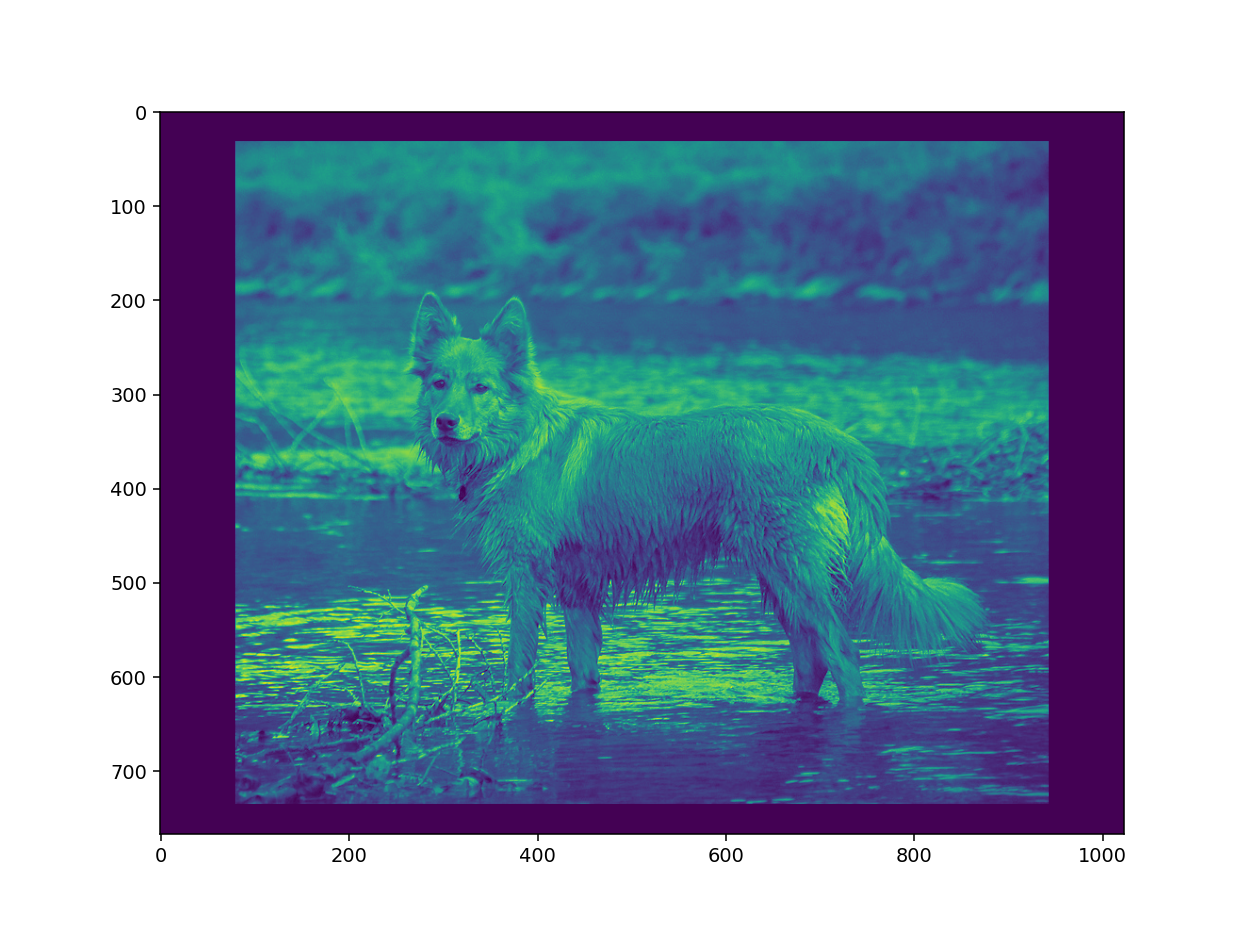

In [57]:
plt.figure()
plt.imshow(img2)

In [46]:
def createPillobxResponse(r, x_size, y_size):
    X,Y = np.meshgrid(np.arange(-1*np.floor(x_size/2),np.floor(x_size/2)+1,1), np.arange(-1*np.floor(y_size/2),np.floor(y_size/2)+1,1))
    psf = np.zeros_like(X)
    psf[np.sqrt(X**2+Y**2) <= r] = 1
    return psf, X, Y

In [49]:
def create_hybrid_image(ratio):
    
    kernel, _, _ = createPillobxResponse(ratio * min(img1.shape[0], img1.shape[1]) / 2, img1.shape[1], img1.shape[0])

    img1_fft = np.fft.fftshift(np.fft.fft2(img1))
    img2_fft = np.fft.fftshift(np.fft.fft2(img2))

    kernel_padded = pad_like(kernel, img1_fft)

    img_res_fft = kernel_padded * img1_fft + (np.ones_like(kernel_padded) - kernel_padded) * img2_fft

    img_res = np.real(np.fft.ifft2(np.fft.ifftshift(img_res_fft)))
    
    #plt.imshow(kernel_padded)
    plt.imshow(img_res, cmap='gray')
    

<IPython.core.display.Javascript object>


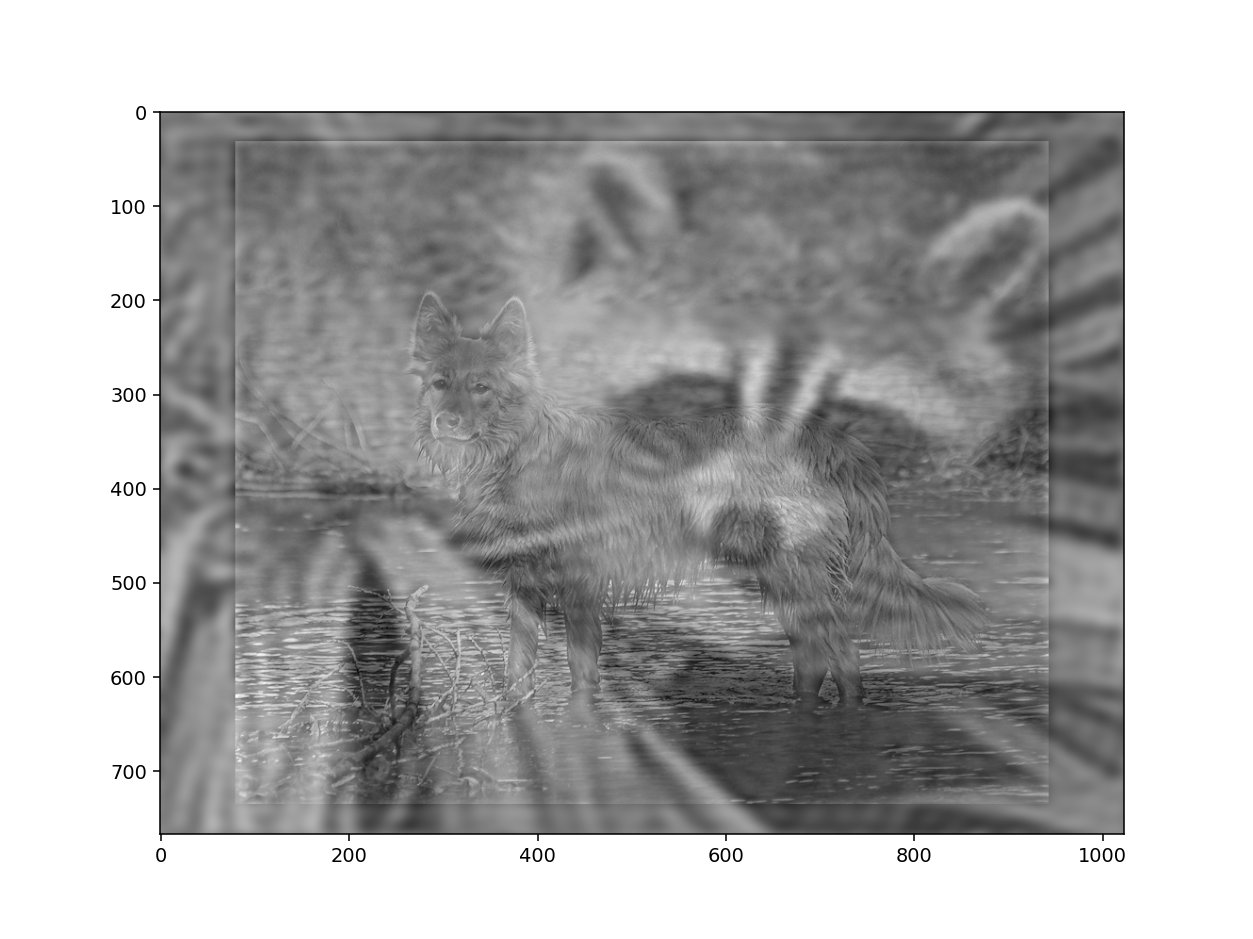

interactive(children=(FloatSlider(value=0.01, description='i', max=0.2, min=0.01, step=0.01), Output()), _dom_…

<function __main__.<lambda>(i)>

In [58]:
plt.figure()
interact(lambda i: create_hybrid_image(i), i=widgets.FloatSlider(min=0.01, max=0.2, step=0.01, value=0.01))

##### Archive

In [ ]:
ratio = 0.08
kernel, _, _ = createPillobxResponse(ratio * min(img1.shape[0], img1.shape[1]) / 2, img1.shape[1], img1.shape[0])

img1_fft = np.fft.fftshift(np.fft.fft2(img1))
img2_fft = np.fft.fftshift(np.fft.fft2(img2))

kernel_padded = pad_like(kernel, img1_fft)

img_res_fft = kernel_padded * img1_fft + (np.ones_like(kernel_padded) - kernel_padded) * img2_fft

img_res = np.real(np.fft.ifft2(np.fft.ifftshift(img_res_fft)))
    

In [ ]:
ratio = 0.08
kernel = np.ones((int(ratio*img1.shape[0]), int(ratio*img1.shape[1])))
if (kernel.shape[0] % 2 == 0):
    kernel = kernel[0:-1,:]
if (kernel.shape[1] % 2 == 0):
    kernel = kernel[:,0:-1]

img1_fft = np.fft.fftshift(np.fft.fft2(img1))
img2_fft = np.fft.fftshift(np.fft.fft2(img2))

kernel_padded = pad_like(kernel, img1_fft)

img_res_fft = kernel_padded * img1_fft + (np.ones_like(kernel_padded) - kernel_padded) * img2_fft

img_res = np.real(np.fft.ifft2(np.fft.ifftshift(img_res_fft)))
    